<h1><center>Credit Risk Analysis</center></h1>
 

### imports

In [1]:

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency,ttest_ind
from sklearn.utils import shuffle
import time

import warnings
warnings.filterwarnings('ignore')


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

# Dataset Visualization


Let's take a quick look at the dataset.


In [3]:
cust_pd_full = pd.read_csv('/mnt/pai/home/josamuel/notebooks/tmp/CUST_HISTORY.csv')

# rows=1000
cust_pd = cust_pd_full # .head(rows)
print("There are " + str(len(cust_pd_full)) + " observations in the customer history dataset.")
print("There are " + str(len(cust_pd_full.columns)) + " variables in the dataset.")

cust_pd.head()

There are 1000 observations in the customer history dataset.
There are 27 variables in the dataset.


,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,IS_URBAN,IS_XBORDER,SELF_REPORTED_ASMT,CO_APPLICANT,GUARANTOR,PRESENT_RESIDENT,OWN_REAL_ESTATE,PROP_UNKN,ESTABLISHED_MONTH,OTHER_INSTALL_PLAN,RENT,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,BRANCHES,TELEPHONE,SHIP_INTERNATIONAL,IS_DEFAULT
0,893,0 USD,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,4,NO,NO,38,YES,NO,YES,2,2,1,NO,YES,No
1,894,0 to 200 USD,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,4,NO,NO,34,NO,NO,YES,2,3,1,YES,NO,No
2,895,NONE,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,NO,YES,NO,NO,NO,above 4 YRS,NO,NO,29,NO,NO,YES,2,3,1,YES,NO,No
3,896,NONE,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,NO,YES,NO,NO,NO,2 to 3 YRS,NO,NO,31,YES,NO,YES,1,4,2,YES,NO,No
4,897,0 USD,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,NO,NO,NO,NO,NO,4,NO,NO,28,NO,YES,NO,1,4,1,YES,NO,No


In [4]:
cust_pd = cust_pd.drop(['MERCHANT', 'BRANCHES','PRESENT_RESIDENT','ACCT_STATUS_K_USD',
                        'SELF_REPORTED_ASMT', 'PROP_UNKN', 'RENT', 'ESTABLISHED_MONTH'],axis=1)

cust_pd.rename(columns={'HISTORY': 'CREDIT_HISTORY', 'ACCT_AGE': 'ACCOUNT_AGE',
                   'CO_APPLICANT': 'HAS_CO_APPLICANT', 'CONTRACT_DURATION_MONTH': 'EMI_TENURE',
                   'GUARANTOR':'HAS_GUARANTOR', 'TELEPHONE': 'OWN_CAR', 
                   'OTHER_INSTALL_PLAN': 'OTHER_INSTALMENT_PLAN',
                   'CREDIT_PROGRAM':'TRANSACTION_CATEGORY','AMOUNT_K_USD':'TRANSACTION_AMOUNT',
                   'IS_XBORDER':'IS_STATE_BORDER'}, inplace=True)



In [5]:
print(cust_pd.shape)
cust_pd.head()

(1000, 19)


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,YES,YES,2,2,NO,YES,No
1,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
2,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
3,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,NO,YES,NO,NO,NO,YES,YES,1,4,YES,NO,No
4,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,NO,NO,NO,NO,NO,NO,NO,1,4,YES,NO,No


In [6]:
cust_pd.to_csv("./CUST_HISTORY_1000.csv", index=False)

# Distribution of data w.r.t Defaulting

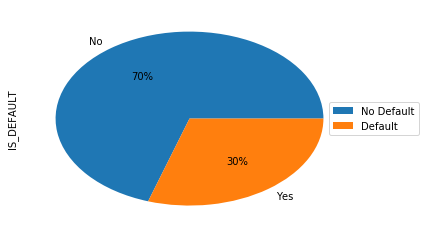

In [133]:
#cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',colormap='winter',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.6))
cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(('No Default', 'Default'), bbox_to_anchor=(1.2, 0.6))

# Default by Transaction Category

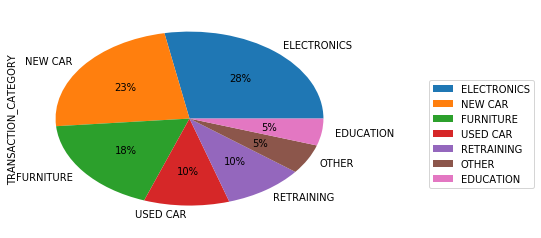

In [134]:
cust_pd.TRANSACTION_CATEGORY.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.7))

* Top 3 credit programs with most Merchants are Electronics(28%), New Car(23%) & Furniture(18%).

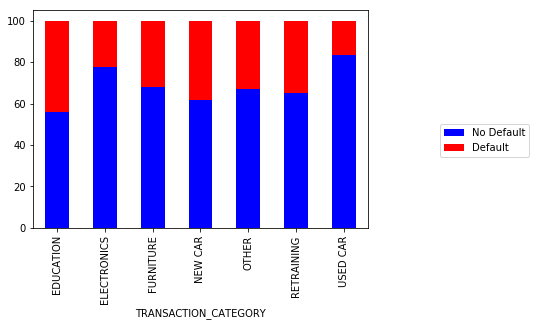

In [135]:
defaults_by_credit_program = cust_pd.groupby(['TRANSACTION_CATEGORY','IS_DEFAULT']).size()
percentages = defaults_by_credit_program.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(('No Default', 'Default'), bbox_to_anchor=(1.2, 0.5))

* Top 3 credit programs with high default rate are Education, New Car and Retraining

# Default rate  - Owning Residence

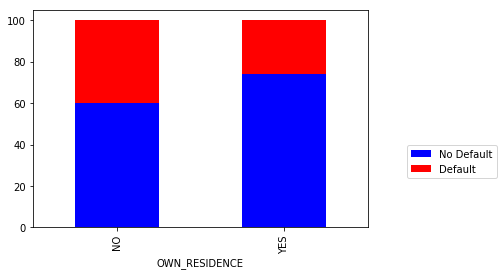

In [136]:
defaults_by_rent = cust_pd.groupby(['OWN_RESIDENCE','IS_DEFAULT']).size()
percentages = defaults_by_rent.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(('No Default', 'Default'),bbox_to_anchor=(1.4, 0.4))

From this stacked bar chart, we can see that Merchants who rent their residence have higher default rate.

# Defaults w.r.t Credit History

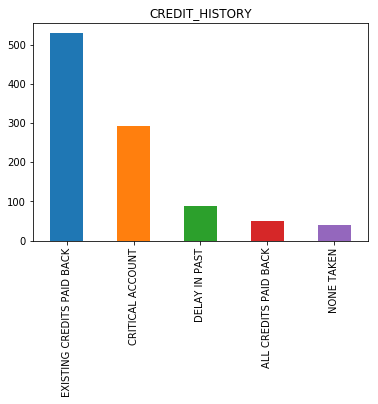

In [137]:
cust_pd.CREDIT_HISTORY.value_counts().plot(kind='bar', title='CREDIT_HISTORY')

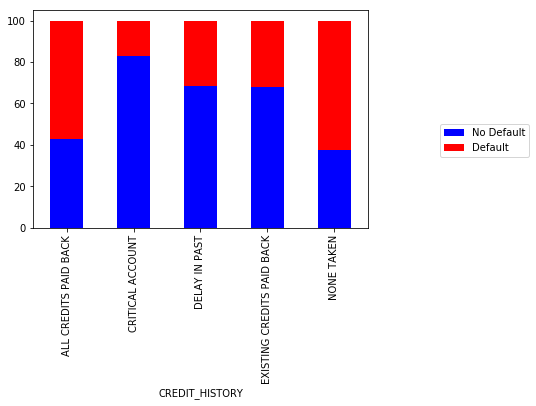

In [138]:
defaults_by_history = cust_pd.groupby(['CREDIT_HISTORY','IS_DEFAULT']).size()
percentages = defaults_by_history.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(('No Default', 'Default'),bbox_to_anchor=(1.2, 0.5))

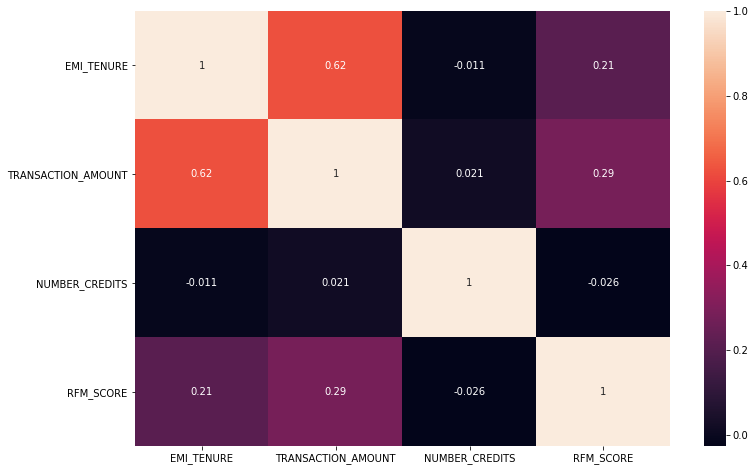

In [139]:
plt.figure(figsize=(12, 8))

corr_df = cust_pd.corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);

# Data Preparation

In [140]:

cust_pd.head()


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,YES,YES,2,2,NO,YES,No
1,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
2,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO,No
3,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,NO,YES,NO,NO,NO,YES,YES,1,4,YES,NO,No
4,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,NO,NO,NO,NO,NO,NO,NO,1,4,YES,NO,No


## Split Dataframe into Features and Label

In [141]:
cust_pd_Y = cust_pd[['IS_DEFAULT']]
cust_pd_X = cust_pd.drop(['IS_DEFAULT'],axis=1)

print('cust_pd_X.shape=%s, cust_pd_Y.shape=%s'% (cust_pd_X.shape, cust_pd_Y.shape))


cust_pd_X.shape=(1000, 18), cust_pd_Y.shape=(1000, 1)


## Transform Label

In [142]:
cust_pd_Y.head()

,IS_DEFAULT
0,No
1,No
2,No
3,No
4,No


In [143]:
le = LabelEncoder()
cust_pd_Y['IS_DEFAULT'] = le.fit_transform(cust_pd_Y['IS_DEFAULT'])
cust_pd_Y.head()

,IS_DEFAULT
0,0
1,0
2,0
3,0
4,0


## Transform Features

In [144]:
print(f'features df shape = {cust_pd_X.shape}')
cust_pd_X.head()

features df shape = (1000, 18)


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL
0,12,CRITICAL ACCOUNT,NEW CAR,2171,up to 100 K USD,1 to 4 YRS,NY,NO,YES,NO,NO,NO,YES,YES,2,2,NO,YES
1,36,CRITICAL ACCOUNT,USED CAR,5800,up to 100 K USD,1 to 4 YRS,CT,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO
2,18,CRITICAL ACCOUNT,ELECTRONICS,1169,UNKNOWN/NONE,1 to 4 YRS,NY,NO,YES,NO,NO,NO,NO,YES,2,3,YES,NO
3,36,DELAY IN PAST,USED CAR,8947,UNKNOWN/NONE,4 to 7 YRS,CT,NO,YES,NO,NO,NO,YES,YES,1,4,YES,NO
4,21,EXISTING CREDITS PAID BACK,ELECTRONICS,2606,up to 100 K USD,up to 1 YR,NY,NO,NO,NO,NO,NO,NO,NO,1,4,YES,NO


### Label Encoder for categorical Columns

In [146]:
categoricalColumns = ['CREDIT_HISTORY', 'TRANSACTION_CATEGORY', 'ACCOUNT_TYPE', 'ACCOUNT_AGE',
                      'STATE', 'IS_URBAN', 'IS_STATE_BORDER', 'HAS_CO_APPLICANT', 'HAS_GUARANTOR',
                      'OWN_REAL_ESTATE', 'OTHER_INSTALMENT_PLAN',
                      'OWN_RESIDENCE', 'RFM_SCORE', 'OWN_CAR', 'SHIP_INTERNATIONAL']
cat_indexes =  [cust_pd_X.columns.get_loc(col) for col in categoricalColumns]
cat_indexes = np.asarray(cat_indexes)   # .ravel()

In [147]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

labelList=[]
labelEncoderList={}
for col in categoricalColumns:
    labenc = LabelEncoder()
    cust_pd_X[col] = labenc.fit_transform(cust_pd_X[col]) 
    labelEncoderList[col] = labenc
    newclas = [col + "_" + str(clas).replace(' ', '_') for clas in labenc.classes_ ]
    labelList.append(np.asarray(newclas))
cust_pd_X.head()

,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL
0,12,1,3,2171,4,0,2,0,1,0,0,0,1,1,2,1,0,1
1,36,1,6,5800,4,0,0,0,1,0,0,0,0,1,2,2,1,0
2,18,1,1,1169,2,0,2,0,1,0,0,0,0,1,2,2,1,0
3,36,2,6,8947,2,1,0,0,1,0,0,0,1,1,1,3,1,0
4,21,3,1,2606,4,4,2,0,0,0,0,0,0,0,1,3,1,0


In [148]:
# np.asarray(labelList)
collabelList = np.concatenate( labelList, axis=0 )

### One hot encoding for categorical Columns

In [149]:
OH_enc = OneHotEncoder(categorical_features=cat_indexes, handle_unknown='ignore', n_values="auto")
OH_enc.fit(cust_pd_X.values)

OneHotEncoder(categorical_features=array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17]),
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values='auto', sparse=True)

In [150]:
# newcols = enc.get_feature_names()
newcols = np.append(collabelList, ["EMI_TENURE", "TRANSACTION_AMOUNT", "NUMBER_CREDITS"])

In [151]:
cust_pd_X_enc = OH_enc.transform(cust_pd_X)
cust_pd_X_df = pd.DataFrame(cust_pd_X_enc.toarray(), columns=newcols)
cust_pd_X_df.head()

,CREDIT_HISTORY_ALL_CREDITS_PAID_BACK,CREDIT_HISTORY_CRITICAL_ACCOUNT,CREDIT_HISTORY_DELAY_IN_PAST,CREDIT_HISTORY_EXISTING_CREDITS_PAID_BACK,CREDIT_HISTORY_NONE_TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW_CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED_CAR,ACCOUNT_TYPE_100_to_500_K_USD,ACCOUNT_TYPE_500_to_1000_K_USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above_1000_K_USD,ACCOUNT_TYPE_up_to_100_K_USD,ACCOUNT_AGE_1_to_4_YRS,ACCOUNT_AGE_4_to_7_YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above_7_YRS,ACCOUNT_AGE_up_to_1_YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,2171.0,2.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,36.0,5800.0,2.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,18.0,1169.0,2.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,36.0,8947.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,21.0,2606.0,1.0


### Feature Normalization 

In [152]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(cust_pd_X_df)
features = min_max_scaler.transform(cust_pd_X_df)
features = normalize(features, axis=1, norm='l1')

cust_pd_X = pd.DataFrame(features,columns=newcols)
cust_pd_X.head()

,CREDIT_HISTORY_ALL_CREDITS_PAID_BACK,CREDIT_HISTORY_CRITICAL_ACCOUNT,CREDIT_HISTORY_DELAY_IN_PAST,CREDIT_HISTORY_EXISTING_CREDITS_PAID_BACK,CREDIT_HISTORY_NONE_TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW_CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED_CAR,ACCOUNT_TYPE_100_to_500_K_USD,ACCOUNT_TYPE_500_to_1000_K_USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above_1000_K_USD,ACCOUNT_TYPE_up_to_100_K_USD,ACCOUNT_AGE_1_to_4_YRS,ACCOUNT_AGE_4_to_7_YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above_7_YRS,ACCOUNT_AGE_up_to_1_YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS
0,0.0,0.064281,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.064281,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.064281,0.064281,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.064281,0.0,0.064281,0.0,0.000000,0.064281,0.064281,0.0,0.064281,0.0,0.064281,0.0,0.000000,0.064281,0.000000,0.064281,0.0,0.064281,0.000000,0.000000,0.064281,0.000000,0.000000,0.064281,0.007562,0.006795,0.021427
1,0.0,0.062076,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.062076,0.0,0.0,0.000000,0.0,0.062076,0.062076,0.000000,0.0,0.0,0.000000,0.062076,0.0,0.000000,0.0,0.062076,0.0,0.000000,0.062076,0.062076,0.0,0.062076,0.0,0.062076,0.0,0.062076,0.000000,0.000000,0.062076,0.0,0.000000,0.062076,0.000000,0.000000,0.062076,0.062076,0.000000,0.029212,0.018957,0.020692
2,0.0,0.064145,0.000000,0.000000,0.0,0.0,0.064145,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.064145,0.0,0.000000,0.064145,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.064145,0.0,0.064145,0.0,0.000000,0.064145,0.064145,0.0,0.064145,0.0,0.064145,0.0,0.064145,0.000000,0.000000,0.064145,0.0,0.000000,0.064145,0.000000,0.000000,0.064145,0.064145,0.000000,0.013206,0.003244,0.021382
3,0.0,0.000000,0.062699,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.062699,0.0,0.0,0.062699,0.0,0.000000,0.000000,0.062699,0.0,0.0,0.000000,0.062699,0.0,0.000000,0.0,0.062699,0.0,0.000000,0.062699,0.062699,0.0,0.062699,0.0,0.062699,0.0,0.000000,0.062699,0.000000,0.062699,0.0,0.000000,0.000000,0.062699,0.000000,0.062699,0.062699,0.000000,0.029506,0.030004,0.000000
4,0.0,0.000000,0.000000,0.065021,0.0,0.0,0.065021,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.065021,0.000000,0.000000,0.0,0.0,0.065021,0.000000,0.0,0.065021,0.0,0.065021,0.0,0.065021,0.000000,0.065021,0.0,0.065021,0.0,0.065021,0.0,0.065021,0.000000,0.065021,0.000000,0.0,0.000000,0.000000,0.065021,0.000000,0.065021,0.065021,0.000000,0.016255,0.008429,0.000000


## Split Train and Test Dataset

In [163]:
label    = cust_pd_Y.values
features  = cust_pd_X.values

label = np.reshape(label,(-1,))
# label = np.float32(label)
X_train,X_test,y_train,y_test = \
       train_test_split(features, label, test_size=0.3, random_state=42, stratify=label)
print(f'X_train.shape={X_train.shape} Y_train.shape={y_train.shape}')
print(f'X_test.shape={X_test.shape} Y_test.shape={y_test.shape}')

X_train.shape=(700, 51) Y_train.shape=(700,)
X_test.shape=(300, 51) Y_test.shape=(300,)


In [164]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
print(y_train.shape)
#Stratify split and train on 5 folds
skf = StratifiedKFold(y_train, n_folds=5)
counter = 1
for train_fold, test_fold in skf:
    random_forest.fit(X_train[train_fold], y_train[train_fold])
    
    print( str(counter) + ": ", random_forest.score(X_train[test_fold], y_train[test_fold]))
    counter += 1 

(700,)
1:  0.7428571428571429
2:  0.6857142857142857
3:  0.7071428571428572
4:  0.7214285714285714
5:  0.6928571428571428


In [166]:
features_order = cust_pd.columns.tolist()

feature_importance_dict = {key: val for key, val in zip(features_order, random_forest.feature_importances_)}

for k in sorted(feature_importance_dict, key=feature_importance_dict.get, reverse=True):
    print(k, feature_importance_dict[k])

OWN_CAR 0.05550904432617789
CREDIT_HISTORY 0.04230984688141736
IS_STATE_BORDER 0.026030724033095365
NUMBER_CREDITS 0.025049289933378866
TRANSACTION_AMOUNT 0.024170348963789452
SHIP_INTERNATIONAL 0.021145514193598954
IS_DEFAULT 0.016388768143918826
IS_URBAN 0.015486651050679845
STATE 0.014319966973767053
OTHER_INSTALMENT_PLAN 0.012780358507690187
EMI_TENURE 0.011406974301130374
OWN_REAL_ESTATE 0.01121448758149422
ACCOUNT_TYPE 0.009643620208969004
HAS_GUARANTOR 0.009329895925415116
ACCOUNT_AGE 0.005634925313858559
HAS_CO_APPLICANT 0.004453162379672506
TRANSACTION_CATEGORY 0.0039125788569566704
RFM_SCORE 0.002613193607025737
OWN_RESIDENCE 0.0024978091401867118


In [185]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, newcols[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature EMI_TENURE (0.049533)
2. feature ACCOUNT_TYPE_up_to_100_K_USD (0.041925)
3. feature TRANSACTION_AMOUNT (0.037002)
4. feature IS_URBAN_NO (0.035170)
5. feature HAS_CO_APPLICANT_NO (0.030183)
6. feature OWN_REAL_ESTATE_NO (0.029590)
7. feature STATE_NY (0.029541)
8. feature HAS_GUARANTOR_NO (0.029195)
9. feature SHIP_INTERNATIONAL_NO (0.028504)
10. feature CREDIT_HISTORY_CRITICAL_ACCOUNT (0.028073)
11. feature OTHER_INSTALMENT_PLAN_NO (0.027992)
12. feature OWN_RESIDENCE_YES (0.027192)
13. feature CREDIT_HISTORY_EXISTING_CREDITS_PAID_BACK (0.025732)
14. feature OWN_CAR_NO (0.024440)
15. feature IS_STATE_BORDER_YES (0.023917)
16. feature ACCOUNT_AGE_up_to_1_YR (0.023813)
17. feature IS_STATE_BORDER_NO (0.023728)
18. feature ACCOUNT_AGE_1_to_4_YRS (0.023670)
19. feature RFM_SCORE_3 (0.023059)
20. feature TRANSACTION_CATEGORY_NEW_CAR (0.021874)
21. feature TRANSACTION_CATEGORY_ELECTRONICS (0.021416)
22. feature ACCOUNT_TYPE_UNKNOWN/NONE (0.021262)
23. feature NUM

# SnapML Training

In [167]:
# Import the LogisticRegression from snap.ml
from snap_ml import LogisticRegression
snapml_lr = LogisticRegression(use_gpu=True, device_ids=[0,1,2,3], 
                        num_threads=1024)


/mnt/pai/home/josamuel/anaconda3/lib/python3.6/site-packages/snap_ml/__init__.py:16: DeprecationWarning: package 'snap_ml' will be deprecated; use 'pai4sk' instead.
  warnings.warn("package 'snap_ml' will be deprecated; use 'pai4sk' instead.", DeprecationWarning)


In [168]:
# Training
t0 = time.time()
snapml_lr.fit(X_train, y_train)
print("[snap.ml] Training time (s):  {0:.2f}".format(time.time()-t0))

[snap.ml] Training time (s):  0.34


In [169]:
# Evaluate accuracy on test set
snapml_prediction = snapml_lr.predict(X_test)
print(f'snap ml accuracy score = {accuracy_score(y_test,snapml_prediction)}')

# proba_test = snapml_lr.predict_proba(X_test)
# from sklearn.metrics import log_loss
# logloss_snap = log_loss(y_test, proba_test)
# print("[snap.ml] Logarithmic loss:   {0:.4f}".format(logloss_snap))

snap ml accuracy score = 0.7


### Prediction

In [170]:
import operator
def predict_listTopFeatures(X, model, colNames):
    mult = X.values[0]*model.coef_
    prediction = model.predict(X.values)
    prediction_prob = model.predict_proba(X.values)

    print("Possibility for defaulting : {} - confidence {:.1f}%".format(
        le.classes_[int(prediction[0])], prediction_prob[0][int(prediction[0])] * 100))
    print()
    print("Key Features which contributes to this outcome: ")
    # Risk free - 0
    if int(prediction[0]) == 0:
        indx = np.where((mult < 0 ))
        negvalues = np.extract((mult < 0 ), mult)
        listwithindex = list(zip(indx[0], negvalues))
        listwithindex.sort(key = operator.itemgetter(1))
        for x in listwithindex[:3]:
            print(colNames[x[0]])
    else:
        indx = np.where((mult > 0 ))
        posvalues = np.extract((mult > 0 ), mult)
        listwithindex = list(zip(indx[0], posvalues))
        listwithindex.sort(key = operator.itemgetter(1), reverse = True)
        for x in listwithindex[:3]:
            print(colNames[x[0]])
            
def preprocess_testDF(test_data, catColumns, labelEncs,
                      onehotEnc, mm_scaler, colNames):
       test_data_X_ = test_data
       for col in catColumns:
           labenc = labelEncs[col]
           test_data_X_[col] = labenc.transform(test_data_X_[col]) 
       test_data_X1_enc = onehotEnc.transform(test_data_X_)

       test_data_X1_enc = pd.DataFrame(test_data_X1_enc.toarray(),columns=newcols)
       features = mm_scaler.transform(test_data_X1_enc)
       features = normalize(features, axis=1, norm='l1')

       test_data_X1_ndf = pd.DataFrame(features,columns=colNames)
       return test_data_X1_ndf



### Predict & List Top Features which influences the outcome

In [171]:
RecNum = 3
test_data = cust_pd.drop(['IS_DEFAULT'],axis=1).iloc[[RecNum]]
Actual=cust_pd['IS_DEFAULT'].iloc[[RecNum]]

test_data_X1_ndf = preprocess_testDF(test_data,
                                    categoricalColumns, labelEncoderList, OH_enc,
                                    min_max_scaler, newcols
                                    )

predict_listTopFeatures(test_data_X1_ndf, snapml_lr, newcols)
print("\nActual : {}".format(Actual.values))

Possibility for defaulting : No - confidence 67.5%

Key Features which contributes to this outcome: 
OWN_RESIDENCE_YES
IS_URBAN_NO
HAS_CO_APPLICANT_NO

Actual : ['No']


In [172]:
labEnc = labelEncoderList['TRANSACTION_CATEGORY']
trans_cat = labEnc.classes_

In [173]:
from ipywidgets import *
import random

style = {'description_width': 'initial'}

RecNum = 3
test_data = cust_pd.iloc[[RecNum]].drop(['IS_DEFAULT'],axis=1)
DELAY_IN_PAST = widgets.Checkbox(value=True if test_data['CREDIT_HISTORY'].values == "DELAY IN PAST" else False,
                                 description='DELAY IN PAST')
TRANSACTION_AMOUNT = widgets.FloatSlider(min=1e3, max=5e4, step=1e3,
                                         description='TRANSACTION AMOUNT', 
                                         value=test_data['TRANSACTION_AMOUNT'].values,
                                         continuous_update=False, style=style,
                                         layout=Layout(width='50%'))
TRANSACTION_CATEGORY = widgets.Dropdown(options=trans_cat,
                                        value=test_data['TRANSACTION_CATEGORY'].values,
                                        description='TRANSACTION CATEGORY', 
                                        style=style, layout=Layout(width='50%'))

ui = widgets.VBox([DELAY_IN_PAST, TRANSACTION_AMOUNT, TRANSACTION_CATEGORY],
                  layout=Layout(padding='10px 10px 10px 10px', border='solid'))



def fpredict(DELAY_IN_PAST, TRANSACTION_AMOUNT, TRANSACTION_CATEGORY):
    test_data = cust_pd.iloc[[RecNum]].drop(['IS_DEFAULT'],axis=1)
    test_data['TRANSACTION_AMOUNT'] = TRANSACTION_AMOUNT
    test_data['TRANSACTION_CATEGORY'] = TRANSACTION_CATEGORY
    test_data['CREDIT_HISTORY'] = "DELAY IN PAST" if DELAY_IN_PAST else "EXISTING CREDITS PAID BACK"
    
    test_data_X1_ndf = preprocess_testDF(test_data,
                                    categoricalColumns, labelEncoderList, OH_enc,
                                    min_max_scaler, newcols
                                    )

    predict_listTopFeatures(test_data_X1_ndf, snapml_lr, newcols)
     
    
out = widgets.interactive_output(fpredict,{'DELAY_IN_PAST': DELAY_IN_PAST,
                                           'TRANSACTION_AMOUNT' : TRANSACTION_AMOUNT,
                                           'TRANSACTION_CATEGORY': TRANSACTION_CATEGORY})

display(ui, out)
button = widgets.Button(description="Pick Random Data!")
display(button)
label = widgets.Label(description="")
display(label)

def randomizeData(b):
    global RecNum
    global test_data
    RecNum = random.randint(1,101)
    test_data = cust_pd.iloc[[RecNum]].drop(['IS_DEFAULT'],axis=1)
    Actual=cust_pd.iloc[[RecNum]]['IS_DEFAULT']
    amt = test_data['TRANSACTION_AMOUNT']
    cat = test_data['TRANSACTION_CATEGORY']
    past = test_data['CREDIT_HISTORY']
    label.value="Actual : {} ".format(Actual.values)
    TRANSACTION_AMOUNT.value = amt
    DELAY_IN_PAST.value = True if test_data['CREDIT_HISTORY'].values == "DELAY IN PAST" else False
    TRANSACTION_CATEGORY.value = cat.values
    

button.on_click(randomizeData)

/mnt/pai/home/josamuel/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  silent = bool(old_value == new_value)


Output()

Button(description='Pick Random Data!', style=ButtonStyle())

Label(value='')

### Visualize the weights

In [174]:
weightage=np.std(X_train, 0)*snapml_lr.coef_

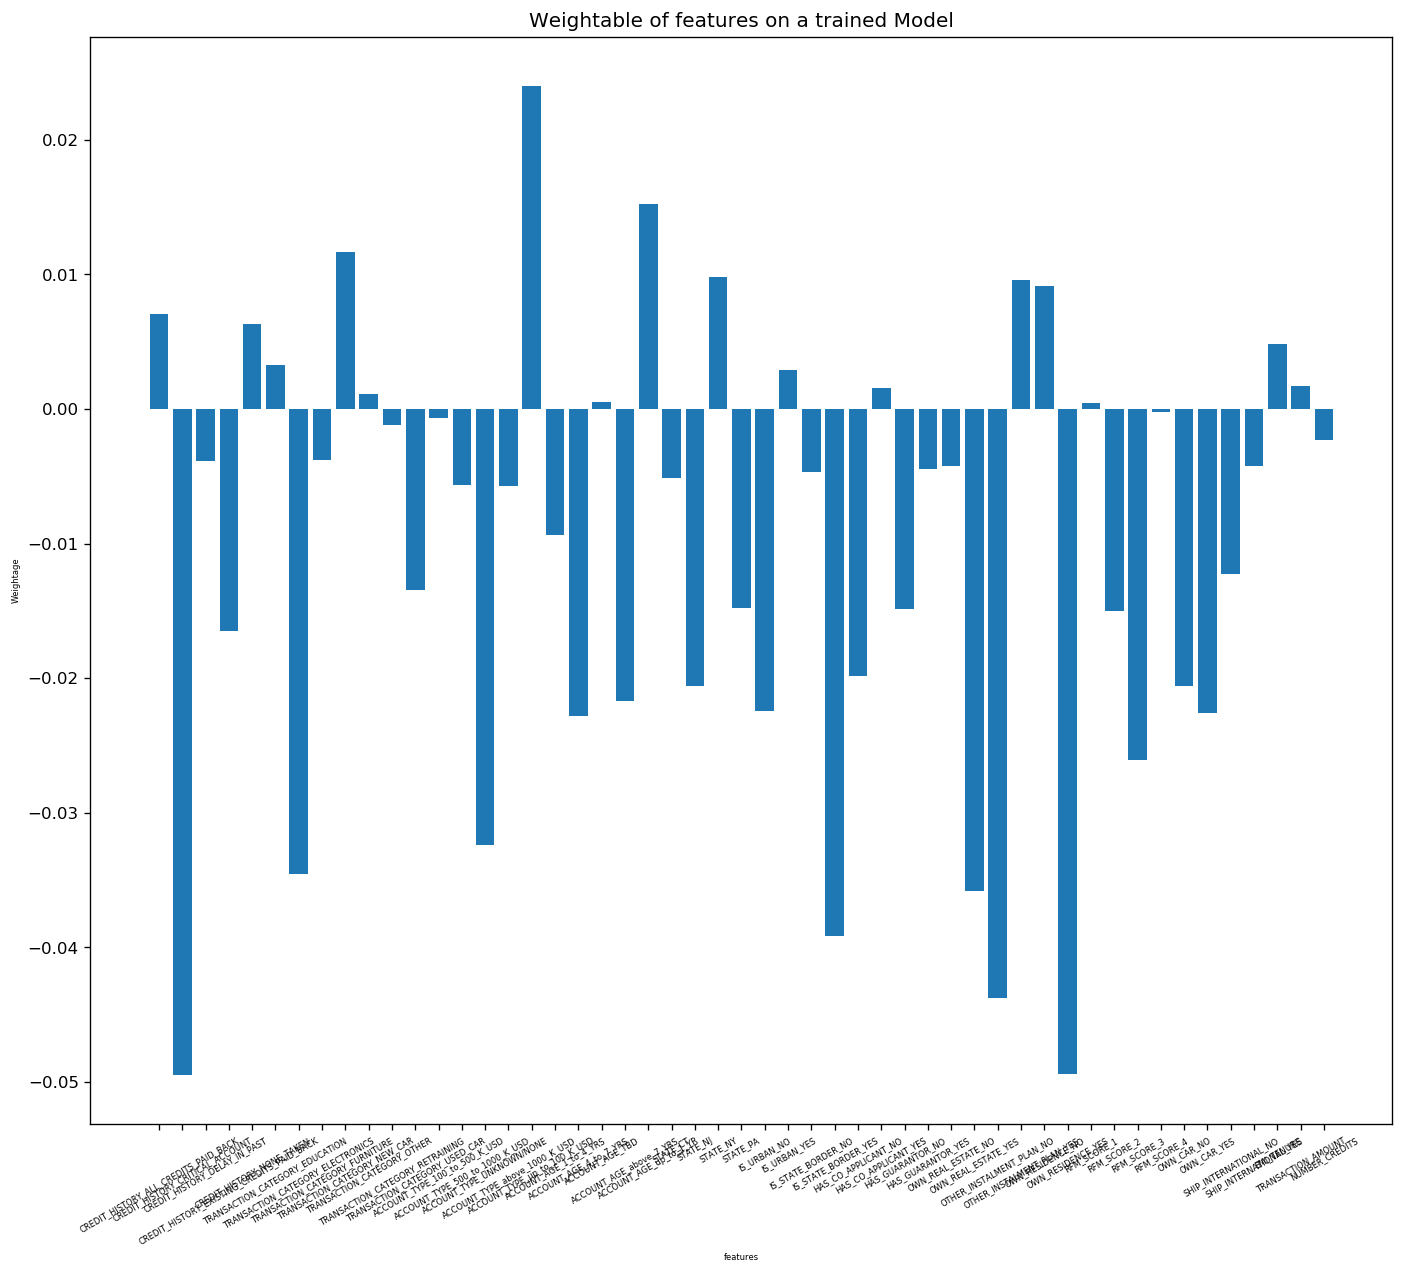

In [175]:
from matplotlib.pyplot import figure
def plot_bar_x():
    
    figure(num=None, figsize=(14, 12), dpi=120, facecolor='w', edgecolor='k')
    label = cust_pd_X.columns
    # this is for plotting purpose
    index = np.arange(len(weightage))
    plt.bar(index, weightage)
    plt.xlabel('features', fontsize=5)
    plt.ylabel('Weightage', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Weightable of features on a trained Model')
    plt.show()
plot_bar_x()

# sklearn Train

In [176]:
# Import
from sklearn.linear_model import LogisticRegression
sklearn_lr = LogisticRegression(verbose=1,max_iter=10)

In [177]:
# TRAIN
t0 = time.time()
sklearn_lr.fit(X_train, y_train)
print("[sklearn] Training time (s):  {0:.5f}".format(time.time()-t0))


[LibLinear][sklearn] Training time (s):  0.00287


In [178]:
# Evaluate log-loss on test set
# proba_test = sklearn_lr.predict_proba(X_test)
# from sklearn.metrics import log_loss
# logloss_sklearn = log_loss(y_test, proba_test)
# print("[sklearn] Logarithmic loss:   {0:.4f}".format(logloss_sklearn))
sklearn_prediction = sklearn_lr.predict(X_test)
print(f'sklearn ml accuracy score = {accuracy_score(y_test,sklearn_prediction)}')

sklearn ml accuracy score = 0.7
